In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import json

%load_ext autoreload
%autoreload 2

In [3]:
# Preview resnet architecture

import torchvision

def temp_hook(module, input, output):
    print(module)
    print("   " + str(output.size()))

preview_model = torchvision.models.resnet18(pretrained=True)
preview_model.type(torch.FloatTensor)

for block in preview_model.children():
    block.register_forward_hook(temp_hook)

dummy_input = Variable(torch.zeros(64,3,224,224)).type(torch.FloatTensor)
preview_model.forward(dummy_input)

print("Parameters: ")
for param in preview_model.parameters():
    print(param.size())


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   torch.Size([64, 64, 112, 112])
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   torch.Size([64, 64, 112, 112])
ReLU (inplace)
   torch.Size([64, 64, 112, 112])
MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
   torch.Size([64, 64, 56, 56])
Sequential (
  (0): BasicBlock (
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  )
  (1): BasicBlock (
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddin

In [30]:
del preview_model

In [2]:
# Preview vgg architecture

import torchvision

def temp_hook(module, input, output):
    print(module)
    print("   " + str(output.size()))

preview_model = torchvision.models.vgg13(pretrained=True)
preview_model.type(torch.FloatTensor)

for block in preview_model.children():
    block.register_forward_hook(temp_hook)

dummy_input = Variable(torch.zeros(64,3,224,224)).type(torch.FloatTensor)
preview_model.forward(dummy_input)

print("Parameters: ")
for param in preview_model.parameters():
    print(param.size())

Sequential (
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU (inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU (inplace)
  (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU (inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU (inplace)
  (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU (inplace)
  (14): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU (inplace)
  (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU (inplace)
  (19): MaxPool2d (

In [22]:
# Test Auxnet, Upsample

from models import AuxNet, Upsample
import torch
import numpy as np

up2x = Upsample(1, factor=2)
up4x = Upsample(1, factor=4)

a1 = torch.mean(torch.rand(64,128,28,28), 1)
a2 = torch.mean(torch.rand(64,256,14,14), 1)
a3 = torch.mean(torch.rand(64,512,7,7), 1)
a1 = Variable(a1)
a2 = up2x(Variable(a2))
a3 = up4x(Variable(a3))
a = torch.cat((a1, a2, a3), dim=1)
print(a.size())

auxnet = AuxNet(28, channels=3)

output = auxnet.forward(a)
print(output.size())

grid = np.random.random((1,1,2,2))
print(grid)
grid_var = Variable(torch.from_numpy(grid)).type(torch.FloatTensor)
grid_var2x = up2x(grid_var)
grid_var4x = up4x(grid_var)
print(grid_var4x)


torch.Size([64, 3, 28, 28])
torch.Size([64, 4])
[[[[ 0.64514233  0.41691449]
   [ 0.96461678  0.64584326]]]]
Variable containing:
(0 ,0 ,.,.) = 
  0.6451  0.6451  0.6451  0.6451  0.4169  0.4169  0.4169  0.4169
  0.6451  0.6451  0.6451  0.6451  0.4169  0.4169  0.4169  0.4169
  0.6451  0.6451  0.6451  0.6451  0.4169  0.4169  0.4169  0.4169
  0.6451  0.6451  0.6451  0.6451  0.4169  0.4169  0.4169  0.4169
  0.9646  0.9646  0.9646  0.9646  0.6458  0.6458  0.6458  0.6458
  0.9646  0.9646  0.9646  0.9646  0.6458  0.6458  0.6458  0.6458
  0.9646  0.9646  0.9646  0.9646  0.6458  0.6458  0.6458  0.6458
  0.9646  0.9646  0.9646  0.9646  0.6458  0.6458  0.6458  0.6458
[torch.FloatTensor of size 1x1x8x8]



In [27]:

from models import ResnetHost, AuxNet, AuxResNet

resnethost = ResnetHost(n_classes=160)
auxnet = AuxNet(224, channels=3)

model = AuxResNet(resnethost, auxnet)

sample_data = Variable(torch.rand(64,3,224,224))
(scores, bbox) = model.forward(sample_data)
print(scores)
print(bbox)


Variable containing:
-7.3530e-01  3.1665e-01  3.2043e-02  ...  -2.9415e-01  3.5306e-01  1.4407e-01
-1.2982e+00  4.4560e-01 -1.9604e-01  ...   1.4995e-01  7.1302e-01 -3.0355e-02
-4.8481e-01  4.7076e-02 -2.8539e-01  ...  -4.2865e-01  2.8335e-01 -5.0417e-01
                ...                   ⋱                   ...                
-7.1426e-01 -2.4111e-02 -1.7653e-01  ...  -3.7614e-01 -1.0771e-01  2.3037e-02
-2.7740e-01  1.6334e-01 -2.3075e-01  ...  -4.1974e-01  6.0509e-01  4.2856e-02
-6.6879e-01  6.1858e-01  4.7331e-01  ...  -4.1039e-02  6.1760e-01  4.3906e-01
[torch.FloatTensor of size 64x160]

Variable containing:
-0.0044  0.2157  0.0684  0.0822
[torch.FloatTensor of size 1x4]



In [15]:
# Test implementation of Intersection over Union, computed over minibatched tensor bboxes

def compute_iou(label_bboxes, output_bboxes):
    """
    Given two bboxes a and b, computes the intersection over union loss
    The bbox format I'm using is a tensor of length 6 in the format [width, height, xmin, ymin, xmax, ymax]
    With batch size N this is an Nx6 tensor
    """
    
    a = label_bboxes # 6 values
    b = output_bboxes # 4 values
    
    # https://stackoverflow.com/questions/27152904/calculate-overlapped-area-between-two-rectangles
    a = a.type(torch.FloatTensor)
    b = b.type(torch.FloatTensor)
    
    a = a.unsqueeze(2)
    b = b.unsqueeze(2)
    a = a[:,2:]
    a_x1, a_y1, a_x2, a_y2 = a[:,0,:], a[:,1,:], a[:,2,:], a[:,3,:]
    b_x1, b_y1, b_x2, b_y2 = b[:,0,:], b[:,1,:], b[:,2,:], b[:,3,:]
    
    print(type((a_x1, b_x1)))
    
    # Intersection
    x1 = torch.cat((a_x1,b_x1), dim=1)
    x2 = torch.cat((a_x2,b_x2), dim=1)
    y1 = torch.cat((a_y1,b_y1), dim=1)
    y2 = torch.cat((a_y2,b_y2), dim=1)
    
    dx = torch.min(x2, 1)[0] - torch.max(x1, 1)[0]
    dy = torch.min(y2, 1)[0] - torch.max(y1, 1)[0]
    
    intersection = torch.clamp(dx*dy, min=0)
        
    # Union
    area_a = (a_x2 - a_x1) * (a_y2 - a_y1)
    area_b =  (b_x2 - b_x1) * (b_y2 - b_y1)
    union = area_a + area_b - intersection
    
    iou = intersection / union
    return iou


In [16]:

bbox1 = torch.from_numpy(np.array([224,224,0,0,224,224])).unsqueeze(0)
bbox2 = torch.from_numpy(np.array([112,112,224,224])).unsqueeze(0)

print(compute_iou(bbox1, bbox2))


<class 'tuple'>

 0.2500
[torch.FloatTensor of size 1x1]



In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):

    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

In [2]:
# Method for superimposing one bounding box on an image.
# To superimpose multiple bboxes, simply run the image through the function multiple times.

import os
import torchvision.transforms as transforms
from PIL import Image
import json

BBOX_PATH = "data/bbox/json/"
def get_bbox(imgpath):
    filename = imgpath.split('/')[-1]
    synset = filename.split('_')[0]
    with open(os.path.join(BBOX_PATH, synset + ".json")) as f:
        bbox_dict = json.load(f)
        bbox = bbox_dict[filename]
    return bbox

def get_img(imgpath):
    return Image.open(imgpath).convert('RGB')

def imgwbbox(img, bbox, rgbcolor=(255,0,0), linewidth=1):
    w = linewidth
    color = torch.from_numpy(np.array(rgbcolor) / 255)
    
    img_tensor = transforms.ToTensor()(img) # This gives a tensor of (channel x height x width)
    if len(bbox) == 6:
        xmin, ymin, xmax, ymax = bbox[2], bbox[3], bbox[4], bbox[5]
    elif len(bbox) == 4:
        xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
    
    # colorx = color.unsqueeze(1).expand(3, ymax-ymin)
    # colory = color.unsqueeze(1).expand(3, xmax-xmin)
    # img_tensor[:,ymin:ymax,xmin] = colorx # left line
    # img_tensor[:,ymin:ymax,xmax] = colorx # right line
    # img_tensor[:,ymin,xmin:xmax] = colory # top line
    # img_tensor[:,ymax,xmin:xmax] = colory # bottom line
    
    # Add line-width support
    if linewidth == 1:
        colorx = color.unsqueeze(1).expand(3, ymax-ymin)
        colory = color.unsqueeze(1).expand(3, xmax-xmin)
    else:
        colorx = color.unsqueeze(1).unsqueeze(2).expand(3, ymax-ymin, w)
        colory = color.unsqueeze(1).unsqueeze(2).expand(3, w, xmax-xmin)
    img_tensor[:,ymin:ymax,xmin:xmin+w] = colorx # left line
    img_tensor[:,ymin:ymax,xmax-w:xmax] = colorx # right line
    img_tensor[:,ymin:ymin+w,xmin:xmax] = colory # top line
    img_tensor[:,ymax-w:ymax,xmin:xmax] = colory # bottom line
    
    bboxed_img = transforms.ToPILImage()(img_tensor)
    return bboxed_img
    

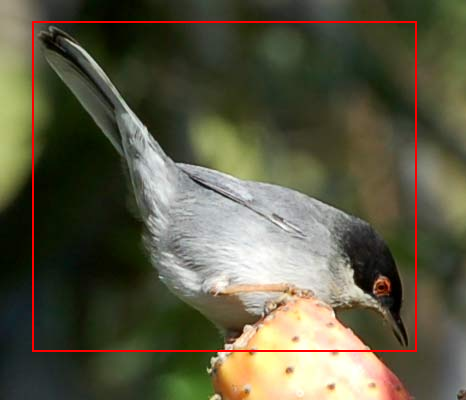

In [105]:
path = "data/images/train/n01503061/n01503061_168.JPEG"
# path = "data/images/train/n01784675/n01784675_1233.JPEG"
img, bbox = get_img(path), get_bbox(path)

imgwbbox(img, bbox, linewidth=2)

In [4]:
# Verify validity of img and target transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Computed sample mean, sdev
mean = np.array([0.48678957, 0.46590506, 0.41864723])
sdev = np.array([0.15854293, 0.15514862, 0.18052906])

IMG_TRANSFORMS = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=sdev)
    ])

REVERSE_IMG_TRANSFORMS = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=(1.0 / sdev).tolist()),
        transforms.Normalize(mean=(-mean).tolist(), std=[1, 1, 1]),
        # Can't reverse crops or scaling as the information is lost
        transforms.ToPILImage(),
    ])

def BBOX_TRANSFORMS(y):
    xmax, ymax = y[0], y[1] # width, height
    x1, y1, x2, y2 = y[2], y[3], y[4], y[5]
    
    # Scale 256: https://github.com/pytorch/vision/blob/master/torchvision/transforms.py
    if (xmax <= ymax and xmax == 256) or (ymax <= xmax and ymax == 256):
        pass
    elif xmax < ymax:
        ymax_new = 256.0 * ymax / xmax
        y1 = int(y1 * (ymax_new / ymax))
        y2 = int(y2 * (ymax_new / ymax))
        ymax = int(ymax_new)
        xmax_new = 256.0
        x1 = int(x1 * (xmax_new / xmax))
        x2 = int(x2 * (xmax_new / xmax))
        xmax = int(xmax_new)
    else:
        xmax_new = 256.0 * xmax / ymax
        x1 = int(x1 * (xmax_new / xmax))
        x2 = int(x2 * (xmax_new / xmax))
        xmax = int(xmax_new)
        ymax_new = 256.0
        y1 = int(y1 * (ymax_new / ymax))
        y2 = int(y2 * (ymax_new / ymax))
        ymax = int(ymax_new)

    # CenterCrop 224
    print(["x", x1, y1, x2, y2])
    
    cx1 = int(round((xmax-224)) / 2.0) # Get crop coordinates
    cy1 = int(round((ymax-224)) / 2.0)
    cx2 = cx1 + 224
    cy2 = cy1 + 224
    
    x1 = min(max(x1, cx1), cx2) - cx1 # Constrain bounds and reset coordinate system
    y1 = min(max(y1, cy1), cy2) - cy1
    x2 = min(max(x2, cx1), cx2) - cx1
    y2 = min(max(y2, cy1), cy2) - cy1
    xmax, ymax = 224, 224

    return np.array([xmax, ymax, x1, y1, x2, y2]).astype(int).tolist()

(294, 500)
torch.Size([3, 224, 224])
['x', 46, 87, 187, 366]
[224, 224, 30, 0, 171, 224]


(-0.5, 223.5, 223.5, -0.5)

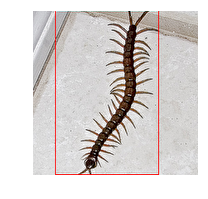

In [106]:
path = "data/images/train/n01784675/n01784675_1233.JPEG"
img, bbox = get_img(path), get_bbox(path)

t_img = IMG_TRANSFORMS(img)
print(img.size)
print(t_img.size())
t_img = REVERSE_IMG_TRANSFORMS(t_img)
t_bbox = BBOX_TRANSFORMS(bbox)
print(t_bbox)
bboxed_img = imgwbbox(t_img, t_bbox, linewidth=1)
plt.subplot(1, 3, 1)
plt.imshow(bboxed_img, interpolation='sinc')
plt.axis('off')

In [5]:
from dataset import AttnDataset

TRAIN_DIR = "data/images/train/"
VAL_DIR = "data/images/val/"
TEST_DIR = "data/images/test/"
BBOX_DIR = "data/bbox/json/"

HOLDOUT_TRAIN_DIR = "data/images/holdout/train/"
HOLDOUT_VAL_DIR = "data/images/holdout/val/"
HOLDOUT_TEST_DIR = "data/images/holdout/test/"

BATCH_SIZE = 64

mean = [0.48678957, 0.46590506, 0.41864723]
sdev = [0.15854293, 0.15514862, 0.18052906]
arrmean = np.array(mean)
arrsdev = np.array(sdev)

IMG_TRANSFORMS = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=sdev)
    ])

REVERSE_IMG_TRANSFORMS = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=(1.0 / arrsdev).tolist()),
        transforms.Normalize(mean=(-arrmean).tolist(), std=[1, 1, 1]),
        # Can't reverse crops or scaling as the information is lost
        transforms.ToPILImage(),
    ])

def BBOX_TRANSFORMS(y):
    synsetid, xmax, ymax = y[0], y[1], y[2] # width, height
    x1, y1, x2, y2 = y[3], y[4], y[5], y[6]
    
    # Scale 256: https://github.com/pytorch/vision/blob/master/torchvision/transforms.py
    
    if (xmax <= ymax and xmax == 256) or (ymax <= xmax and ymax == 256):
        pass
    elif xmax < ymax:
        ymax_new = 256.0 * ymax / xmax
        y1 = int(y1 * (ymax_new / ymax))
        y2 = int(y2 * (ymax_new / ymax))
        ymax = int(ymax_new)
        xmax_new = 256.0
        x1 = int(x1 * (xmax_new / xmax))
        x2 = int(x2 * (xmax_new / xmax))
        xmax = int(xmax_new)
    else:
        xmax_new = 256.0 * xmax / ymax
        x1 = int(x1 * (xmax_new / xmax))
        x2 = int(x2 * (xmax_new / xmax))
        xmax = int(xmax_new)
        ymax_new = 256.0
        y1 = int(y1 * (ymax_new / ymax))
        y2 = int(y2 * (ymax_new / ymax))
        ymax = int(ymax_new)

    # CenterCrop 224
    
    cx1 = int(round((xmax-224)) / 2.0) # Get crop coordinates
    cy1 = int(round((ymax-224)) / 2.0)
    cx2 = cx1 + 224
    cy2 = cy1 + 224
    
    x1 = min(max(x1, cx1), cx2) - cx1 # Constrain bounds and reset coordinate system
    y1 = min(max(y1, cy1), cy2) - cy1
    x2 = min(max(x2, cx1), cx2) - cx1
    y2 = min(max(y2, cy1), cy2) - cy1
    xmax, ymax = 224, 224

    return np.array([synsetid, xmax, ymax, x1, y1, x2, y2]).astype(int)


train_bbox_data = AttnDataset(TRAIN_DIR, BBOX_DIR, 
                              transform=IMG_TRANSFORMS, target_transform=BBOX_TRANSFORMS)
train_bbox_loader = DataLoader(train_bbox_data, batch_size=BATCH_SIZE, shuffle=True)


val_bbox_data = AttnDataset(VAL_DIR, BBOX_DIR, 
                            transform=IMG_TRANSFORMS, target_transform=BBOX_TRANSFORMS)
val_bbox_loader = DataLoader(val_bbox_data, batch_size=BATCH_SIZE, shuffle=True)


test_bbox_data = AttnDataset(TEST_DIR, BBOX_DIR, 
                             transform=IMG_TRANSFORMS, target_transform=BBOX_TRANSFORMS)
test_bbox_loader = DataLoader(test_bbox_data, batch_size=BATCH_SIZE, shuffle=True)


holdout_train_bbox_data = AttnDataset(HOLDOUT_TRAIN_DIR, BBOX_DIR, 
                                      transform=IMG_TRANSFORMS, target_transform=BBOX_TRANSFORMS)
holdout_train_bbox_loader = DataLoader(holdout_train_bbox_data, batch_size=BATCH_SIZE, shuffle=True)


holdout_val_bbox_data = AttnDataset(HOLDOUT_VAL_DIR, BBOX_DIR, 
                                    transform=IMG_TRANSFORMS, target_transform=BBOX_TRANSFORMS)
holdout_val_bbox_loader = DataLoader(holdout_val_bbox_data, batch_size=BATCH_SIZE, shuffle=True)


holdout_test_bbox_data = AttnDataset(HOLDOUT_TEST_DIR, BBOX_DIR, 
                                     transform=IMG_TRANSFORMS, target_transform=BBOX_TRANSFORMS)
holdout_test_bbox_loader = DataLoader(holdout_test_bbox_data, batch_size=BATCH_SIZE, shuffle=True)

print("Datasets loaded.")

Datasets loaded.


In [7]:
from models import ResnetHost, AuxNet, AuxResNet

N_TRAIN_CLASSES = 160

# Load training host (resnet) and freeze all parameters
train_host_resnet = ResnetHost(n_classes=N_TRAIN_CLASSES)
train_host_resnet.load_state_dict(torch.load("data/models/train_resnet_session_0_epoch_10.checkpoint"))
train_host_resnet.freeze_weights()

# Initialize new auxnet
aux_net = AuxNet(spatial_size=28, channels=3)

# Define the full network
train_net = AuxResNet(train_host_resnet, aux_net)
train_net.cuda()
train_net.load_state_dict(torch.load("data/models/train_full_session_10_epoch_1.checkpoint"))


N_TEST_CLASSES = 38

# Load test host (resnet) and freeze all parameters
test_host_resnet = ResnetHost(n_classes=N_TEST_CLASSES)
test_host_resnet.load_state_dict(torch.load("data/models/test_resnet_session_0_epoch_16.checkpoint"))
test_host_resnet.cuda()
test_host_resnet.freeze_weights()

# Load trained auxnet
aux_net = train_net.auxnet
aux_net.freeze_weights()

test_net = AuxResNet(test_host_resnet, aux_net)
# If we want to override weights, uncomment below
test_net.load_state_dict(torch.load("data/models/test_newaux_full_session_0_epoch_4.checkpoint"))

test_net.cuda()



AuxResNet (
  (resnethost): ResnetHost (
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (relu): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (maxpool): ReLU (inplace)
    (bn): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (conv2_x): Sequential (
      (0): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), st

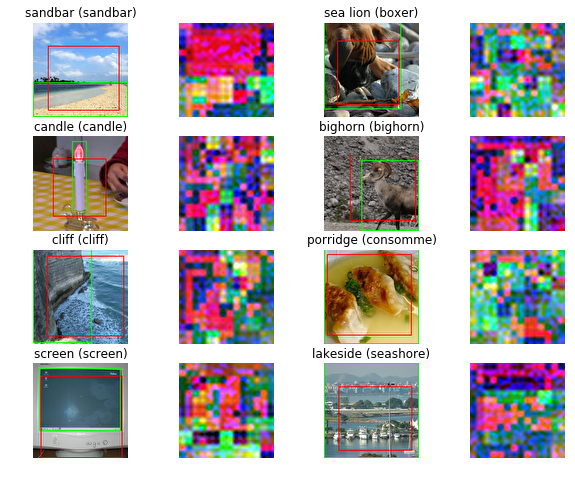

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'sinc'
plt.rcParams['image.cmap'] = 'gray'

model = train_net
dataset = train_bbox_data
dataloader = train_bbox_loader

# model = test_net
# dataset = holdout_val_bbox_data
# dataloader = holdout_val_bbox_loader

normalize = transforms.Normalize(mean=[0,0,0], std=[1,1,1])
to_pil_image = transforms.ToPILImage()
def rgb_weight_heatmap(img_tensor):
    img_tensor = normalize(img_tensor) * 10
    img = to_pil_image(img_tensor)
    return img


classidx_to_synset_dict = dataset.idx_to_class
synset_to_name_dict = None
with open(os.path.join("data/named_populated_synsets.json")) as f:
    synset_to_name_dict = json.load(f)
    

for minibatch, (x, y) in enumerate(dataloader):
    x_var = Variable(x.type(torch.cuda.FloatTensor), volatile=True)
    labels = y[:,0]
    label_bboxes = y[:,1:]
    
    (scores, bboxes) = model.forward(x_var)
    bboxes = torch.clamp(bboxes.data, min=0, max=224)
    bboxes = bboxes.type(torch.cuda.IntTensor)
    
    weights = model.get_wouts(x_var, as_separate_channels=False).data.cpu()
    
    _, preds = scores.data.max(1) # argmax
    preds = preds.squeeze().cpu().numpy()
    
    for i in range(8):
        img = REVERSE_IMG_TRANSFORMS(x_var.data[i,:,:,:].cpu())
        img = imgwbbox(img, label_bboxes[i], rgbcolor=(0,255,0), linewidth=2)
        img = imgwbbox(img, bboxes[i], linewidth=2)
        
        predicted_label = synset_to_name_dict[classidx_to_synset_dict[preds[i]]]
        true_label = synset_to_name_dict[classidx_to_synset_dict[labels[i]]]
        
        heatmap = rgb_weight_heatmap(weights[i])
        plt.rcParams['image.interpolation'] = 'sinc'
        plt.subplot(4, 4, 2*i+1)
        plt.title(predicted_label + " (" + true_label + ")")
        plt.imshow(img)
        plt.axis('off')
        plt.rcParams['image.interpolation'] = 'sinc'
        plt.subplot(4, 4, 2*i+2)
        plt.imshow(heatmap)
        plt.axis('off')
    
    # print(bboxes)
    break
print("")